<a href="https://colab.research.google.com/github/scadusseau/RL-Algorithms-generalization-framework-/blob/master/Project_Cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project cat

> Project cat est un environnement simple utilisant des images comme états.

> Project cat is a simple environnement which use images as states. 

In [0]:
#Voici les differentes importations dont cette solution a besoin
#You can find here the different librairies needed to make the solution working.

#Importations basiques et génériques
#Basicals importations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import cv2
import random as rand

#Pour l'agent et spécifiquement le petit réseau de neurones.
#For the agent and specifically the little neurals network.
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam

#Pour creer le lien avec google drive
#In order to create a link with google drive
from google.colab import drive

Using TensorFlow backend.


In [0]:
#Pour monter notre volume google drive
#In order to mount our google drive volume
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


> La classe de l'environnement avec des images de chat

> The environnement class with cat images

In [0]:
"""
Dans cette partie nous écrivons notre environnement se basant sur une série d'image de chat.
Le but de l'agent à travers cette environnement est de dessiner le rectangle qui encadre le mieux la tête du chat.
  Cette environnement fonctionne de la manière suivante:
  - Il récupère une image sur le disque de l'ordinateur ou sur un volume Google drive dans notre exemple.
  - Il récupère un fichier d'information associer qui renseigne des points définissant des parties importantes du visage du chat.
  - A partir de cette ensemble de point, un rectangle minimal possèdant chaque point est calculé.
    - Ce rectangle minimal correspond à notre encadrement de la tête de l'animal optimal.
  - Deux points P1 et P2 sont initialisés aléatoirement dans l'image.
    - Ces points correspondent aux extrémitées du rectangle.
      - P1 est le point 
      - P2 est le point  
  - Selon l'action choisit, on déplace P1 et P2 et on dessine un nouveau rectangle.
  - Selon la proximité entre le rectangle optimal et notre rectangle (distance entre les extrémités) nous établissons la récompense.  
"""

"""
In this part we write our environment based on several cat images.
The goal of the agent in this environment is to draw a rectangle which framed the best the cat's head.
  This environment works the following way:
  - It takes an image in the disk or a Google drive volume.
  - It takes an information file associated which give use multiple points defining important parts of cat's visage.
  - With those points the minimal rectangle is calculated.
    - This rectangle is the best framing of the cat's head.
  - Two points P1 and P2 are randomly initialised in the image.
    - Those points are the rectangle's extremities.
      - P1 is the 
      - P2 is the
  - Following the choiced action, we move P1 and P2 and we draw a new rectangle.
  - Following the proximity betwin the optimal rectangle and our rectangle (distance betwin each extremities), we make up the reward. 
"""

class Chat_Env:
  """
  # INITIALISATION DE L ENVIRONNEMENT
  # ENVIRONMENT INITIALIZATION
  """
  def __init__(self, id_im, nb_tour_max=7000):

    # Nombres d'étapes max dans l'épisode
    # Maximum steps in one episode
    self.nb_tour_max = nb_tour_max
    self.iter = 0

    # La vitesse de déplacement des points
    # The deplacement speed of points
    self.depl = 1

    # Les actions
    # The actions
    self.nb_actions = 16
    self.list_actions = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

    # Lecture de l'image
    # Image reading
    self.id = id_im
    self.image = np.array(Image.open('/content/gdrive/My Drive/CAT_00/('+ str(self.id) +').jpg'), dtype=np.uint8)

    self.dimensions = self.image.shape

    # Initialisation aléatoire des points
    # Setting up the points randomly
    self.P1 = [rand.randrange(0, int(self.dimensions[0]/2) )  ,  rand.randrange(0, int(self.dimensions[1]/2) ) ]
    self.P2 = [rand.randrange(1+ int(self.dimensions[0]/2) , self.dimensions[0])  ,  rand.randrange(1+ int(self.dimensions[1]/2) , self.dimensions[1]-20)]

    # Importation des informations du fichier d'information de l'image (les points important du chat)
    # Catching infoFile informations (the important points of the cat)
    self.infoFile = open('/content/gdrive/My Drive/CAT_00/('+ str(self.id) +').cat', 'r')
    self.infoString = self.infoFile.read()
    self.info = []
    j=0
    temp = ""
    for i in range (len(self.infoString)):
      if (self.infoString[i] == ' '):
        self.info.append(int(temp))
        temp = ""
      else:
        temp = temp + self.infoString[i]
    self.infoFile.close()

    # Fabrication du rectangle minimal
    # Making up of the minimal rectangle
    self.Rect = self.minAreaRect(self.info)

    # Definition de l'état de départ
    # First state initialisation
    self.ENV = self.drawing_rect(self.image, self.P1, self.P2)


  """
  # FONCTIONS PRIMORDIALES (fonctions piliers)
  # MOST IMPORTANT FUNCTIONS (based functions)
  """


  # La fonction step qui prend en argument une action et renvoie l'état suivant, la récompense et un indicatif de fin
  # Takes an action and return the following state, the reward and if the environment is ended or not
  def step(self, action):
    self.iter = self.iter + 1

    if (action == 0):
      if (self.P1[0] + self.depl <= self.dimensions[0] and self.P1[0] + self.depl >= 0):
        self.P1[0] = self.P1[0] + self.depl
    if (action == 1):
      if (self.P1[0] - self.depl <= self.dimensions[0] and self.P1[0] - self.depl >= 0):
        self.P1[0] = self.P1[0] - self.depl
    if (action == 2):
      if (self.P1[1] + self.depl <= self.dimensions[1] and self.P1[1] + self.depl >= 0):
        self.P1[1] = self.P1[1] + self.depl
    if (action == 3):
      if (self.P1[1] - self.depl <= self.dimensions[1] and self.P1[1] - self.depl >= 0):
        self.P1[1] = self.P1[1] - self.depl
    if (action == 4):
      if (self.P2[0] + self.depl <= self.dimensions[0] and self.P2[0] + self.depl >= 0):
        self.P2[0] = self.P2[0] + self.depl
    if (action == 5):
      if (self.P2[0] - self.depl <= self.dimensions[0] and self.P2[0] - self.depl >= 0):
        self.P2[0] = self.P2[0] - self.depl
    if (action == 6):
      if (self.P2[1] + self.depl <= self.dimensions[1] and self.P2[1] + self.depl >= 0):
        self.P2[1] = self.P2[1] + self.depl
    if (action == 7):
      if (self.P2[1] - self.depl <= self.dimensions[1] and self.P2[1] - self.depl >= 0):
        self.P2[1] = self.P2[1] - self.depl
    if (action == 8):
      if (self.P1[0] + self.depl*5 <= self.dimensions[0] and self.P1[0] + self.depl*5 >= 0):
        self.P1[0] = self.P1[0] + self.depl*5
    if (action == 9):
      if (self.P1[0] - self.depl*5 <= self.dimensions[0] and self.P1[0] - self.depl*5 >= 0):
        self.P1[0] = self.P1[0] - self.depl*5
    if (action == 10):
      if (self.P1[1] + self.depl*5 <= self.dimensions[1] and self.P1[1] + self.depl*5 >= 0):
        self.P1[1] = self.P1[1] + self.depl*5
    if (action == 11):
      if (self.P1[1] - self.depl*5 <= self.dimensions[1] and self.P1[1] - self.depl*5 >= 0):
        self.P1[1] = self.P1[1] - self.depl*5
    if (action == 12):
      if (self.P2[0] + self.depl*5 <= self.dimensions[0] and self.P2[0] + self.depl*5 >= 0):
        self.P2[0] = self.P2[0] + self.depl*5
    if (action == 13):
      if (self.P2[0] - self.depl*5 <= self.dimensions[0] and self.P2[0] - self.depl*5 >= 0):
        self.P2[0] = self.P2[0] - self.depl*5
    if (action == 14):
      if (self.P2[1] + self.depl*5 <= self.dimensions[1] and self.P2[1] + self.depl*5 >= 0):
        self.P2[1] = self.P2[1] + self.depl*5
    if (action == 15):
      if (self.P2[1] - self.depl*5 <= self.dimensions[1] and self.P2[1] - self.depl*5 >= 0):
        self.P2[1] = self.P2[1] - self.depl*5

    done = False

    reward = -self.euclidianDist(self.P1,self.Rect[0]) - self.euclidianDist(self.P2,self.Rect[1])
    if (reward == 0):
      done = True
    if (self.iter == self.nb_tour_max):
      done = True
    
    self.image = np.array(Image.open('/content/gdrive/My Drive/CAT_00/('+ str(self.id) +').jpg'), dtype=np.uint8)
    self.image = self.drawing_rect(self.image, self.P1, self.P2)

    return self.image, reward, done

  # La fonction pour mettre à zero l'environnement
  # The function to bring back to zero the environment
  def reset(self):
    self.iter = 0
    self.image = np.array(Image.open('/content/gdrive/My Drive/CAT_00/('+ str(self.id) +').jpg'), dtype=np.uint8)

    self.dimensions = self.image.shape

    self.P1 = [rand.randrange(0, int(self.dimensions[0]/2) )  ,  rand.randrange(0, int(self.dimensions[1]/2) ) ]
    self.P2 = [rand.randrange(1+ int(self.dimensions[0]/2) , self.dimensions[0])  ,  rand.randrange(1+ int(self.dimensions[1]/2) , self.dimensions[1]-20)]


  """
  # Fonctions d'aide au fonctionnement
  # Functions helping to work
  """


  #Trouver le rectangle minimum à partir de plusieurs points
  #Python finding the minimum rectangle out of multiple points
  def minAreaRect(self, A):
    X1,Y1 = 10000,10000
    X2,Y2 = -10000, -10000
    
    for i in range(1,2*A[0]):
      if (i%2 == 0):
        if (A[i] < Y1):
          Y1 = A[i]
        if (A[i] > Y2):
          Y2 = A[i]
      else:
        if (A[i] < X1):
          X1 = A[i]
        if (A[i] > X2):
          X2 = A[i]
    Y2 = Y2 + 20
    return [[X1,Y1],[X2,Y2]]

  #Trouver hauteur et largeur d'un rectangle
  #Finding width and height
  def WandH(self, P1, P2):
    return [P2[0]-P1[0],P2[1]-P1[1]]

  # Fonction de calcul de distance euclidienne pour la récompense
  # Euclidian distance calcul for reward making
  def euclidianDist(self, R1, R2):
    return ((R2[0] - R1[0])**2 + (R2[1] - R1[1])**2)**(1/2)

  # Fonction de dessin d'un rectangle sur l'image
  # Function of drawing rectangle in the image
  def drawing_rect(self, image, P1, P2):
    cv2.rectangle(image, (P1[0],P1[1]), (P2[0],P2[1]), (255,255,255), thickness=3, lineType=8, shift=0)
    return image


  '''
  # Fonctions optionnelles
  # Optionnal functions
  '''


  # Fonction d'affichage de l'état de l'environnement
  # Displaying the state of the environment
  def affiche(self):
    print("Dimension " + str(self.dimensions[0]) + " " + str(self.dimensions[1])) 
    print("P1 " + str(self.P1))
    print("P2 " + str(self.P2))
    fig,ax = plt.subplots(1)
    ax.imshow(self.image)
    plt.show()
    plt.close()

  # Fonction d'affichage de l'objectif à atteindre
  # Displaying of the goal to achieve
  def affiche_objectif(self):
    print("Dimension " + str(self.dimensions[0]) + " " + str(self.dimensions[1])) 
    print("P1 objectif " + str(self.Rect[0]))
    print("P2 objectif " + str(self.Rect[1]))

    print("Les distances :")
    print("P1 et Rect[0] " + str(self.P1) + " " + str(self.Rect[0]) + " distance -> " + str(self.euclidianDist(self.P1,self.Rect[0])))
    print("P2 et Rect[1] " + str(self.P2) + " " + str(self.Rect[1]) + " distance -> " + str(self.euclidianDist(self.P2,self.Rect[1])))

    #fig,ax = plt.subplots(1)

    #self.image_obj = np.array(Image.open('/content/gdrive/My Drive/CAT_00/('+ str(self.id) +').jpg'), dtype=np.uint8)
    #self.image_obj = self.drawing_rect(self.image_obj , self.Rect[0], self.Rect[1])

    #ax.imshow(self.image_obj )
    #plt.show()
    #plt.close()


  '''
  # En chantier
  # Work in progress
  '''


  #Optionnel pour changer d'image en cours de route !!!/!\ EN CONSTRUCTION /!\!!!
  def change_id(self, id):
    self.id = id

    self.image = np.array(Image.open('/content/gdrive/My Drive/CAT_00/('+ str(self.id) +').jpg'), dtype=np.uint8)

    self.dimensions = self.image.shape

    self.P1 = [rand.randrange(0, int(self.dimensions[0]/2) )  ,  rand.randrange(0, int(self.dimensions[1]/2) ) ]
    self.P2 = [rand.randrange(1+ int(self.dimensions[0]/2) , self.dimensions[0])  ,  rand.randrange(1+ int(self.dimensions[1]/2) , self.dimensions[1]-20)]

    self.infoFile = open('/content/gdrive/My Drive/CAT_00/('+ str(self.id) +').cat', 'r')
    self.infoString = self.infoFile.read()

    self.info = []
    j=0

    temp = ""

    for i in range (len(self.infoString)):
      if (self.infoString[i] == ' '):
        self.info.append(int(temp))
        temp = ""
      else:
        temp = temp + self.infoString[i]

    self.Rect = self.minAreaRect(self.info)
    self.ENV = self.drawing_rect(self.image, self.P1, self.P2)

    self.infoFile.close()

    self.reset()

DQN

In [0]:
class ReplayBuffer(object):
  def __init__(self, max_size, input_shape, n_actions, discrete=False):
    self.mem_size = max_size
    self.mem_cntr = 0
    self.input_shape = input_shape
    self.discrete = discrete
    self.state_memory = np.zeros((self.mem_size, input_shape))
    self.new_state_memory = np.zeros((self.mem_size, input_shape))
    dtype = np.int8 if self.discrete else np.float32
    self.action_memory = np.zeros((self.mem_size, n_actions), dtype = dtype)
    self.reward_memory = np.zeros(self.mem_size)
    self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

  def store_transition(self, state, action, reward, state_, done):
    index = self.mem_cntr % self.mem_size
    self.state_memory[index] = state
    self.new_state_memory[index] = state_
    self.reward_memory[index] = reward
    self.terminal_memory[index] = 1 - int(done)
    if self.discrete:
      actions = np.zeros(self.action_memory.shape[1])
      actions[action] = 1.0
      self.action_memory[index] = actions
    else:
      self.action_memory[index] = action
    self.mem_cntr += 1

  def sample_buffer(self, batch_size):
    max_mem = min(self.mem_cntr, self.mem_size)
    batch = np.random.choice(max_mem, batch_size)

    states = self.state_memory[batch]
    states_ = self.new_state_memory[batch]
    rewards = self.reward_memory[batch]
    actions = self.action_memory[batch]
    terminal = self.terminal_memory[batch]

    return states, actions, rewards, states_, terminal

def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
  model = Sequential([Dense(fc1_dims, input_shape=(input_dims, )),
                      Activation('relu'),
                      Dense(fc2_dims),
                      Activation('relu'),
                      Dense(n_actions)])
  model.compile(optimizer=Adam(lr=lr), loss='mse')

  return model

class Agent(object):
  def __init__(self, alpha, gamma, n_actions, epsilon, batch_size,
               input_dims, epsilon_dec=0.996, epsilon_end=0.01,
               mem_size=5000, fname='dqn_model_CAT.h5'):
    self.action_space = [i for i in range(n_actions)]
    self.n_actions = n_actions
    self.gamma = gamma
    self.epsilon = epsilon
    self.epsilon_dec = epsilon_dec
    self.epsilon_min = epsilon_end
    self.batch_size = batch_size
    self.model_file = fname

    self.memory = ReplayBuffer(mem_size, input_dims, n_actions, discrete=True)
    self.q_eval = build_dqn(alpha, n_actions, input_dims, 256, 256)
  
  def remember(self, state, action, reward, new_state, done):
    self.memory.store_transition(state, action, reward, new_state, done)

  def choose_action(self, state):
    state = state[np.newaxis, :]
    rand = np.random.random()
    if rand < self.epsilon:
      action = np.random.choice(self.action_space)
    else:
      actions = self.q_eval.predict(state)
      action = np.argmax(actions)

    return action

  def learn(self):
    if self.memory.mem_cntr < self.batch_size:
      return
    state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)
    action_values = np.array(self.action_space, dtype=np.int8)
    action_indices = np.dot(action, action_values)

    q_eval = self.q_eval.predict(state)
    q_next = self.q_eval.predict(new_state)

    q_target = q_eval.copy()

    batch_index = np.arange(self.batch_size, dtype=np.int32)

    q_target[batch_index, action_indices] = reward + self.gamma*np.max(q_next, axis=1)*done

    _ = self.q_eval.fit(state, q_target, verbose=0)

    self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > self.epsilon_min else self.epsilon_min

  def save_model(self):
    path = "/content/gdrive/My Drive/"+self.model_file 
    self.q_eval.save(path)

  def load_model(self):
    path = "/content/gdrive/My Drive/"+self.model_file  
    self.q_eval = load_model(path)

Test





loading








loaded
Nouvelle partie 1

..............
Objectif -> 
Dimension 333 500
P1 objectif [93, 9]
P2 objectif [281, 189]
Les distances :
P1 et Rect[0] [6, 144] [93, 9] distance -> 160.60510577189007
P2 et Rect[1] [244, 369] [281, 189] distance -> 183.76343488300387
Dimension 333 500
P1 [6, 144]
P2 [244, 369]


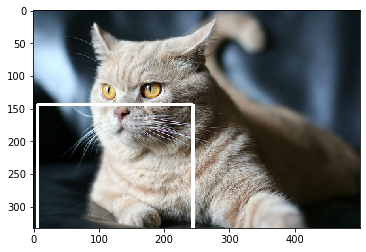

-344.36854065489393

 SCORE MOYEN 
1
-344.36854065489393

saving
saved

reseting
reset !
Nouvelle partie 2

..............
Objectif -> 
Dimension 333 500
P1 objectif [93, 9]
P2 objectif [281, 189]
Les distances :
P1 et Rect[0] [214, 299] [93, 9] distance -> 314.2308068920041
P2 et Rect[1] [310, 128] [281, 189] distance -> 67.54257916307313
Dimension 333 500
P1 [214, 299]
P2 [310, 128]


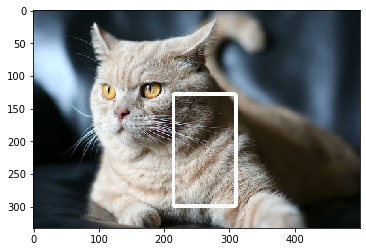

-381.77338605507725

 SCORE MOYEN 
2
-363.07096335498557

saving
saved

reseting
reset !
Nouvelle partie 3

..............
Objectif -> 
Dimension 333 500
P1 objectif [93, 9]
P2 objectif [281, 189]
Les distances :
P1 et Rect[0] [82, 191] [93, 9] distance -> 182.33211456021672
P2 et Rect[1] [333, 85] [281, 189] distance -> 116.27553482998907
Dimension 333 500
P1 [82, 191]
P2 [333, 85]


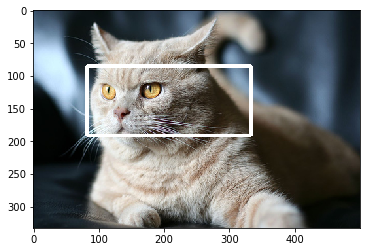

-298.6076493902058

 SCORE MOYEN 
3
-341.5831920333923

saving
saved

reseting
reset !
Nouvelle partie 4

..............
Objectif -> 
Dimension 333 500
P1 objectif [93, 9]
P2 objectif [281, 189]
Les distances :
P1 et Rect[0] [47, 392] [93, 9] distance -> 385.75251133336775
P2 et Rect[1] [331, 284] [281, 189] distance -> 107.35455276791944
Dimension 333 500
P1 [47, 392]
P2 [331, 284]


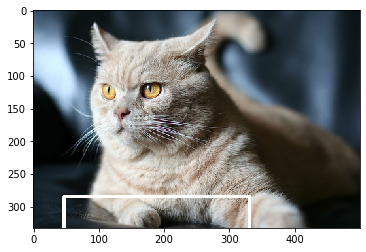

-493.10706410128716

 SCORE MOYEN 
4
-379.464160050366

saving
saved

reseting
reset !
Nouvelle partie 5

..............
Objectif -> 
Dimension 333 500
P1 objectif [93, 9]
P2 objectif [281, 189]
Les distances :
P1 et Rect[0] [321, 497] [93, 9] distance -> 538.6353126188442
P2 et Rect[1] [303, 478] [281, 189] distance -> 289.836160614924
Dimension 333 500
P1 [321, 497]
P2 [303, 478]


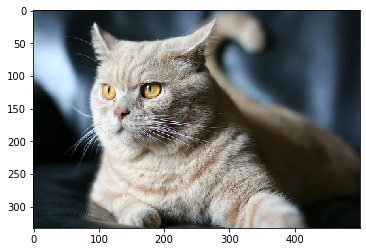

-828.4714732337682

 SCORE MOYEN 
5
-469.2656226870464

saving
saved

reseting
reset !
Nouvelle partie 6

..............
Objectif -> 
Dimension 333 500
P1 objectif [93, 9]
P2 objectif [281, 189]
Les distances :
P1 et Rect[0] [312, 326] [93, 9] distance -> 385.2920969861697
P2 et Rect[1] [4, 400] [281, 189] distance -> 348.209706929603
Dimension 333 500
P1 [312, 326]
P2 [4, 400]


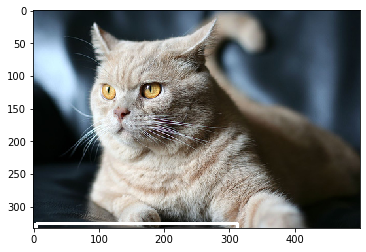

-733.5018039157727

 SCORE MOYEN 
6
-513.3049862251675

saving
saved

reseting
reset !
Nouvelle partie 7

..............
Objectif -> 
Dimension 333 500
P1 objectif [93, 9]
P2 objectif [281, 189]
Les distances :
P1 et Rect[0] [294, 457] [93, 9] distance -> 491.02443931030564
P2 et Rect[1] [317, 314] [281, 189] distance -> 130.080744155313
Dimension 333 500
P1 [294, 457]
P2 [317, 314]


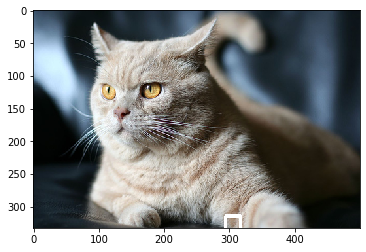

-621.1051834656187

 SCORE MOYEN 
7
-528.7050144023748

saving
saved

reseting
reset !
Nouvelle partie 8

..............
Objectif -> 
Dimension 333 500
P1 objectif [93, 9]
P2 objectif [281, 189]
Les distances :
P1 et Rect[0] [283, 0] [93, 9] distance -> 190.21303845951255
P2 et Rect[1] [325, 334] [281, 189] distance -> 151.52887513606112
Dimension 333 500
P1 [283, 0]
P2 [325, 334]


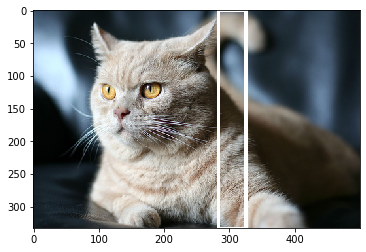

-341.7419135955737

 SCORE MOYEN 
8
-505.3346268015246

saving
saved

reseting
reset !
Nouvelle partie 9

..............
Objectif -> 
Dimension 333 500
P1 objectif [93, 9]
P2 objectif [281, 189]
Les distances :
P1 et Rect[0] [284, 2] [93, 9] distance -> 191.12822920751398
P2 et Rect[1] [264, 45] [281, 189] distance -> 145.0
Dimension 333 500
P1 [284, 2]
P2 [264, 45]


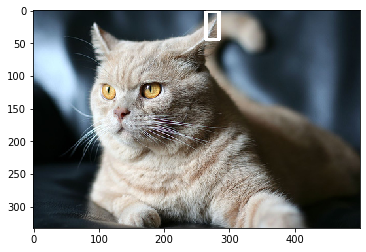

-336.128229207514

 SCORE MOYEN 
9
-486.5339159577457

saving
saved

reseting
reset !
Nouvelle partie 10

..............
Objectif -> 
Dimension 333 500
P1 objectif [93, 9]
P2 objectif [281, 189]
Les distances :
P1 et Rect[0] [27, 23] [93, 9] distance -> 67.468511173732
P2 et Rect[1] [205, 0] [281, 189] distance -> 203.70812453115363
Dimension 333 500
P1 [27, 23]
P2 [205, 0]


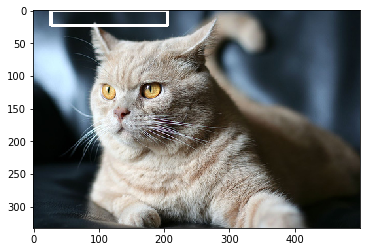

-271.1766357048856

 SCORE MOYEN 
10
-464.9981879324597

saving
saved

reseting
reset !
Nouvelle partie 11

..............
Objectif -> 
Dimension 333 500
P1 objectif [93, 9]
P2 objectif [281, 189]
Les distances :
P1 et Rect[0] [96, 138] [93, 9] distance -> 129.0348790056394
P2 et Rect[1] [315, 4] [281, 189] distance -> 188.09837851507388
Dimension 333 500
P1 [96, 138]
P2 [315, 4]


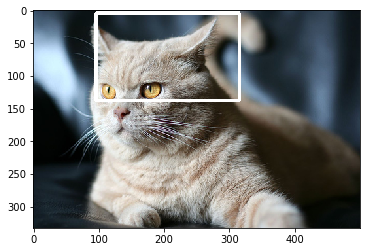

-317.1332575207133

 SCORE MOYEN 
11
-451.55592153139185

saving
saved

reseting
reset !
Nouvelle partie 12

..............
Objectif -> 
Dimension 333 500
P1 objectif [93, 9]
P2 objectif [281, 189]
Les distances :
P1 et Rect[0] [166, 0] [93, 9] distance -> 73.55270219373317
P2 et Rect[1] [82, 69] [281, 189] distance -> 232.38115241989829
Dimension 333 500
P1 [166, 0]
P2 [82, 69]


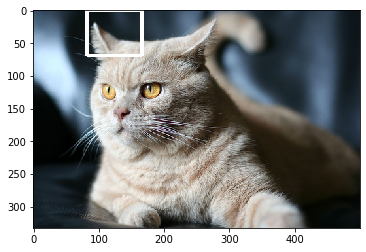

-305.93385461363147

 SCORE MOYEN 
12
-439.42074928824513

saving
saved

reseting
reset !
Nouvelle partie 13

..............
Objectif -> 
Dimension 333 500
P1 objectif [93, 9]
P2 objectif [281, 189]
Les distances :
P1 et Rect[0] [312, 2] [93, 9] distance -> 219.1118435867856
P2 et Rect[1] [272, 39] [281, 189] distance -> 150.26975743641833
Dimension 333 500
P1 [312, 2]
P2 [272, 39]


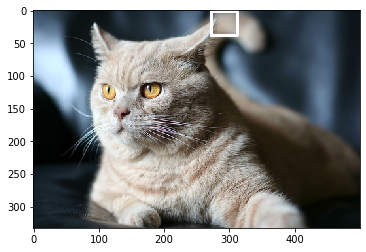

-369.3816010232039

 SCORE MOYEN 
13
-434.0331224986266

saving
saved

reseting
reset !
Nouvelle partie 14

..............
Objectif -> 
Dimension 333 500
P1 objectif [93, 9]
P2 objectif [281, 189]
Les distances :
P1 et Rect[0] [226, 26] [93, 9] distance -> 134.08206442324789
P2 et Rect[1] [255, 0] [281, 189] distance -> 190.77997798511248
Dimension 333 500
P1 [226, 26]
P2 [255, 0]


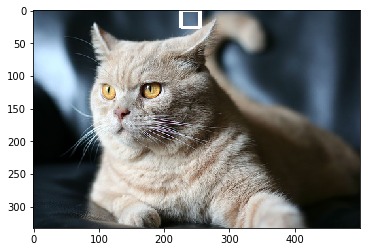

-324.86204240836037

 SCORE MOYEN 
14
-426.23518820646467

saving
saved

reseting
reset !
Nouvelle partie 15

..............
Objectif -> 
Dimension 333 500
P1 objectif [93, 9]
P2 objectif [281, 189]
Les distances :
P1 et Rect[0] [7, 213] [93, 9] distance -> 221.38653978957257
P2 et Rect[1] [275, 498] [281, 189] distance -> 309.0582469373694
Dimension 333 500
P1 [7, 213]
P2 [275, 498]


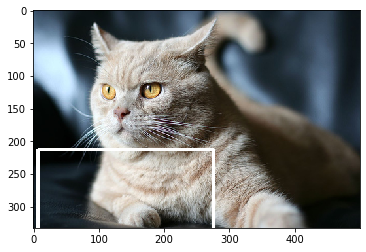

-530.444786726942

 SCORE MOYEN 
15
-433.1824947744965

saving
saved

reseting
reset !
Nouvelle partie 16

..............
Objectif -> 
Dimension 333 500
P1 objectif [93, 9]
P2 objectif [281, 189]
Les distances :
P1 et Rect[0] [33, 0] [93, 9] distance -> 60.67124524847005
P2 et Rect[1] [199, 455] [281, 189] distance -> 278.3522947633089
Dimension 333 500
P1 [33, 0]
P2 [199, 455]


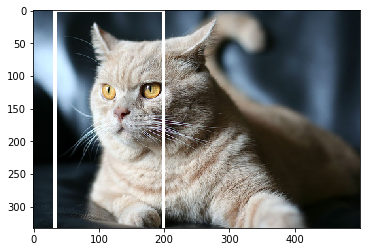

-339.02354001177895

 SCORE MOYEN 
16
-427.29756010182666

saving
saved

reseting
reset !
Nouvelle partie 17

..............
Objectif -> 
Dimension 333 500
P1 objectif [93, 9]
P2 objectif [281, 189]
Les distances :
P1 et Rect[0] [22, 500] [93, 9] distance -> 496.1068433311518
P2 et Rect[1] [132, 24] [281, 189] distance -> 222.31958978011812
Dimension 333 500
P1 [22, 500]
P2 [132, 24]


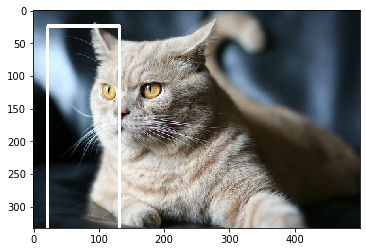

-718.42643311127

 SCORE MOYEN 
17
-444.42278792591156

saving
saved

reseting
reset !
Nouvelle partie 18

..............
Objectif -> 
Dimension 333 500
P1 objectif [93, 9]
P2 objectif [281, 189]
Les distances :
P1 et Rect[0] [39, 2] [93, 9] distance -> 54.45181356024793
P2 et Rect[1] [112, 65] [281, 189] distance -> 209.6115454835444
Dimension 333 500
P1 [39, 2]
P2 [112, 65]


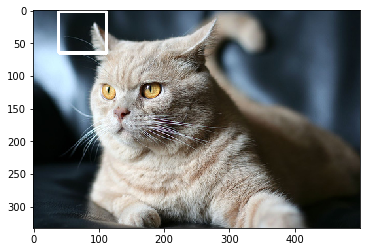

-264.06335904379233

 SCORE MOYEN 
18
-434.4028196546827

saving
saved

reseting
reset !
Nouvelle partie 19

..............
Objectif -> 
Dimension 333 500
P1 objectif [93, 9]
P2 objectif [281, 189]
Les distances :
P1 et Rect[0] [22, 0] [93, 9] distance -> 71.56814934033156
P2 et Rect[1] [131, 167] [281, 189] distance -> 151.6047492659778
Dimension 333 500
P1 [22, 0]
P2 [131, 167]


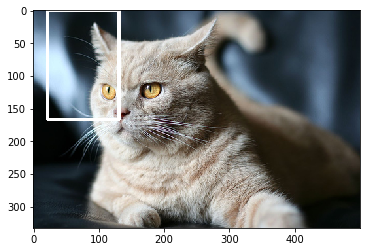

-223.17289860630936

 SCORE MOYEN 
19
-423.2854553889788

saving
saved

reseting
reset !
Nouvelle partie 20

..............
Objectif -> 
Dimension 333 500
P1 objectif [93, 9]
P2 objectif [281, 189]
Les distances :
P1 et Rect[0] [124, 2] [93, 9] distance -> 31.78049716414141
P2 et Rect[1] [326, 313] [281, 189] distance -> 131.91285001848757
Dimension 333 500
P1 [124, 2]
P2 [326, 313]


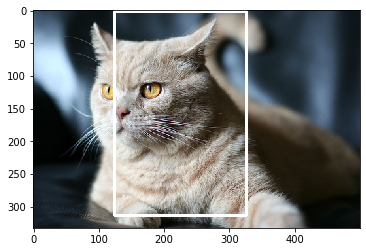

-163.693347182629

 SCORE MOYEN 
20
-410.30584997866134

saving
saved

reseting
reset !
Nouvelle partie 21

..............
Objectif -> 
Dimension 333 500
P1 objectif [93, 9]
P2 objectif [281, 189]
Les distances :
P1 et Rect[0] [294, 0] [93, 9] distance -> 201.20139164528658
P2 et Rect[1] [224, 434] [281, 189] distance -> 251.54323684011064
Dimension 333 500
P1 [294, 0]
P2 [224, 434]


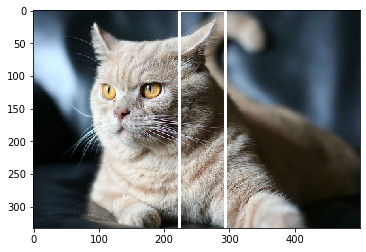

-452.74462848539724

 SCORE MOYEN 
21
-412.32674419326787

saving
saved

reseting
reset !
Nouvelle partie 22

....

In [0]:
id_image = 5
env = Chat_Env(id_image)

def preprocess1(img):
    return cv2.resize(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), (84, 90))

def preprocess(img):
    return np.matrix.flatten(cv2.resize(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), (84, 90)))

n_games = 500

agent = Agent(gamma=0.90, epsilon=1.0, alpha=0.20, input_dims=7560, n_actions = env.nb_actions,
              mem_size=80000, batch_size=500, epsilon_end=0.05, fname='DQN_CHAT5_test.h5')

print("loading")
agent.load_model()
print("loaded")

points = 0

scores = []
eps_history = []

n_partie = 0

list_rewards = []

for i in range(n_games):
  n_partie = n_partie + 1
  print("Nouvelle partie " + str(n_partie))
  print()
  done = False
  observation = env.ENV
  observation = preprocess(observation)
  while not done:
    action = agent.choose_action(observation)
    observation_, reward, done = env.step(action)

    observation_ = preprocess(observation_)
    scores.append(reward)
    agent.remember(observation, action, reward, observation_, done)
    observation = observation_

    points = points + 1

    if (points == 500):
      agent.learn()
      print(".", end = '')
      points = 0

  print()
  print("Objectif -> ")
  env.affiche_objectif()
  env.affiche()
  print(reward)

  print()
  list_rewards.append(reward)
  print(" SCORE MOYEN ")
  print(len(list_rewards))
  moyenne = sum(list_rewards)/len(list_rewards)

  print(moyenne)
  print()
  
  print("saving")
  agent.save_model()
  print("saved")

  print()

  print("reseting")
  env.reset()
  print("reset !")
  